In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 981.0 kB/s eta 0:00:00


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
class ShapeChecker():
  def __init__(self):
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
from pathlib import Path
import numpy as np
def load_data(path_to_file):
    path = Path(path_to_file)
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context

In [ ]:
path_to_file = "sample_data/training_c.txt"
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Se podra otorgar agua para usos no previstos, respetando las disposiciones de la presente Ley.


In [ ]:
print(target_raw[-1])

Chicham Umiktin jintiaja umikmau diisa, jujui tachamu akuish, tikichnum yumi atsumnakuig takastinai.


In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Por tanto, no reine el pecado en vuestro cuerpo mortal, de modo que le obedezc\xc3\xa1is en sus concupiscencias.'
 b'Despu\xc3\xa9s de cantar el himno, salieron al monte de los Olivos.'
 b'especie de bejuco'
 b'Y cuando la gente ve\xc3\xada que la columna de nube se deten\xc3\xada a la entrada de la tienda, cada uno se arrodillaba a la entrada de su propia tienda en actitud de adoraci\xc3\xb3n.'
 b'Que no se hable mal de vuestro bien:'], shape=(5,), dtype=string)

tf.Tensor(
[b'Nuadu\xc3\xad atumek tudauk tak\xc3\xa1 batsaamaitsugme, atumi iyashim pegkegchaun takastatus wakega nun\xc3\xba takaakjum.'
 b'Nuna timatai kantamtain kantamawag, Olivosan mujajin wegajui.'
 b'da\xc3\xa9k pau'
 b'Nuna aents aidau wainainak, maki makichik dita Apaju\xc3\xadn wajuk emamatin ainawa nunisag dit\xc3\xa1 aakjin waitinum tikishmajag pujujaku ainawai.'
 b'Nu atum: Ju yutai yuwakuish tudauk wemaitsuapi, tayatkugmesh yatsut Apajuin tupanmain wainkugmek idaisatajum, nuna diis tikich aidau pe

In [ ]:
example_text = tf.constant('Uziasa uchijiyai Jotam, Jotama uchijiyai Acaz, Acaza uchijiyai Ezequias.')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Uziasa uchijiyai Jotam, Jotama uchijiyai Acaz, Acaza uchijiyai Ezequ\xc3\xadas.'
b'Uziasa uchijiyai Jotam, Jotama uchijiyai Acaz, Acaza uchijiyai Ezequi\xcc\x81as.'


In [ ]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Uziasa uchijiyai Jotam, Jotama uchijiyai Acaz, Acaza uchijiyai Ezequias.
[START] uziasa uchijiyai jotam ,  jotama uchijiyai acaz ,  acaza uchijiyai ezequias . [END]


In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', '[START]', '[END]', 'y', '.', 'de', 'que', 'el']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', '.', '[START]', '[END]', 'aents', 'nuna', 'apajui', 'aidau']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[3, 16, 105, 2, 14, 3653, 9, 232, 13, 264, 246, 2608, 2, 7, 468, 8, 23, 1,
  13, 36, 2082, 6, 4]                                                      ,
 [3, 90, 7, 3913, 9, 1, 2, 374, 21, 240, 7, 12, 1358, 6, 4],
 [3, 2473, 7, 3534, 4]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] por tanto , no reine el pecado en vuestro cuerpo mortal , de modo que le [UNK] en sus concupiscencias . [END]'

Text(0.5, 1.0, 'Mask')

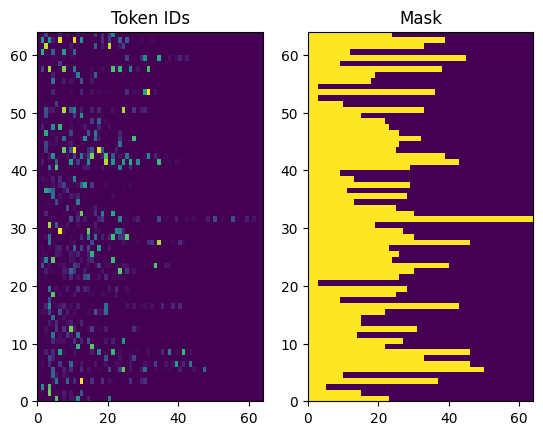

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   3   26   13    9  456  119   64 2733   22 1129]

[   4   49    8  298 3442   70 2267  241    2   75]
[  49    8  298 3442   70 2267  241    2   75    1]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')
    x = self.embedding(x)
    shape_checker(x, 'batch s units')
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:

encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 121)
Encoder output, shape (batch, s, units): (64, 121, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 121, 256)
Target sequence, shape (batch, t, units): (64, 73, 256)
Attention result, shape (batch, t, units): (64, 73, 256)
Attention weights, shape (batch, t, s):    (64, 73, 121)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 0.9999999 , 1.0000001 , 1.        , 1.        ,
       1.        , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 ], dtype=float32)

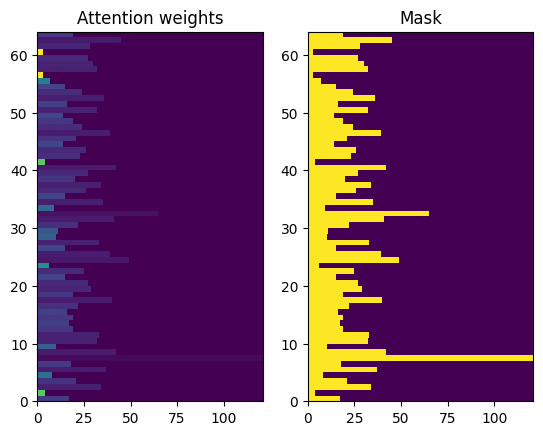

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.attention = CrossAttention(units)

    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 121, 256)
input target tokens shape: (batch, t) (64, 73)
logits shape shape: (batch, target_vocabulary_size) (64, 73, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  done = done | (next_token == self.end_token)
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:

next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  tokens.append(next_token)

tokens = tf.concat(tokens, axis=-1)

result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'pujuti ibaush umiakjumek nuwiyati waitinak uchijum akateak kuichkin nunikaju akushkam',
       b'iniaschajui jopan yumijin manoa batsatuk nugkashkam weaku yapajia agak inamjatin',
       b'yaja puyatjukag chichajuidau kuitamkattagme nuniakjumesh jegatnai wenakua amainaitji nicodemo wekama'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 121)
Target tokens, shape: (batch, t) (64, 73)
logits, shape: (batch, t, target_vocabulary_size) (64, 73, 5000)


In [ ]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 7s 20ms/step - loss: 8.5198 - masked_acc: 3.2238e-04 - masked_loss: 8.5198


{'loss': 8.51983642578125,
 'masked_acc': 0.00032238126732409,
 'masked_loss': 8.51983642578125}

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 24s 110ms/step - loss: 5.7200 - masked_acc: 0.1875 - masked_loss: 5.7200 - val_loss: 5.0475 - val_masked_acc: 0.2560 - val_masked_loss: 5.0475
Epoch 2/100
100/100 [==============================] - 8s 78ms/step - loss: 4.8109 - masked_acc: 0.2677 - masked_loss: 4.8109 - val_loss: 4.4568 - val_masked_acc: 0.2895 - val_masked_loss: 4.4568
Epoch 3/100
100/100 [==============================] - 6s 55ms/step - loss: 4.3411 - masked_acc: 0.2940 - masked_loss: 4.3411 - val_loss: 4.0548 - val_masked_acc: 0.3141 - val_masked_loss: 4.0548
Epoch 4/100
100/100 [==============================] - 5s 51ms/step - loss: 3.9127 - masked_acc: 0.3176 - masked_loss: 3.9127 - val_loss: 3.9075 - val_masked_acc: 0.3161 - val_masked_loss: 3.9075
Epoch 5/100
100/100 [==============================] - 4s 40ms/step - loss: 3.7527 - masked_acc: 0.3243 - masked_loss: 3.7527 - val_loss: 3.7300 - val_masked_acc: 0.3254 - val_masked_loss: 3.7300
Epoch 6/100
100/10

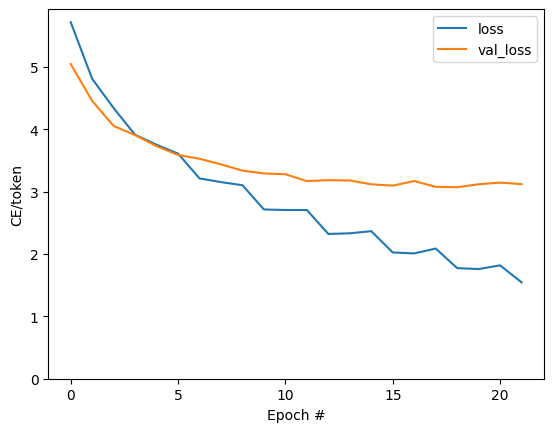

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

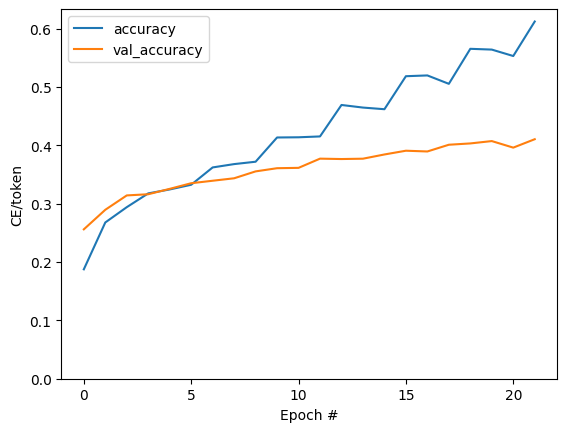

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  tokens = tf.concat(tokens, axis=-1)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['Habiendo dicho estas cosas, se arrodillo y oro con todos ellos.'])
result[0].numpy().decode()

'juna tusa idayak , ashi tikich apajuin shiig [UNK] , nuigtu ashi ditajai ijunag batsataina jusha ashi [UNK] tusa [UNK] . '